In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize, to_pil_image
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
import math

# 超参数
image_size = 512
timesteps = 8  # 噪声步数
batch_size = 8
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 计算PSNR
def calculate_psnr(pred, target, max_value=1.0):
    mse = nn.MSELoss()(pred, target)
    psnr = 10 * torch.log10((max_value ** 2) / mse)
    return psnr

# 计算SSIM
def calculate_ssim(pred, target):
    # 将Tensor转换为numpy数组
    pred = pred.permute(0, 2, 3, 1).cpu().numpy()
    target = target.permute(0, 2, 3, 1).cpu().numpy()
    
    ssim_score = 0
    batch_size = pred.shape[0]
    
    for i in range(batch_size):
        ssim_score += ssim(pred[i], target[i], multichannel=True, channel_axis = 2, data_range = 1.0)
    
    return ssim_score / batch_size  # 返回平均值

class CloudDataset(Dataset):
    def __init__(self, cloud_dir, clear_dir, transform=None):
        """
        cloud_dir: 存放有云雾图像的文件夹路径
        clear_dir: 存放无云图像的文件夹路径
        transform: 图像预处理函数
        """
        self.cloud_dir = cloud_dir
        self.clear_dir = clear_dir
        self.transform = transform
        
        # 获取所有文件名（假设文件名一一对应）
        self.cloud_files = sorted(os.listdir(cloud_dir))
        self.clear_files = sorted(os.listdir(clear_dir))

    def __len__(self):
        return len(self.cloud_files)

    def __getitem__(self, idx):
        # 读取图像
        cloud_path = os.path.join(self.cloud_dir, self.cloud_files[idx])
        clear_path = os.path.join(self.clear_dir, self.clear_files[idx])
        
        cloud_img = Image.open(cloud_path).convert("RGB")  # 确保为 RGB 格式
        clear_img = Image.open(clear_path).convert("RGB")
        
        # 应用预处理
        if self.transform:
            cloud_img = self.transform(cloud_img)
            clear_img = self.transform(clear_img)
        
        return cloud_img, clear_img

# 数据文件夹路径
cloud_dir = r"D:\DataSet\RICE_DATASET\RICE1\cloud"
clear_dir = r"D:\DataSet\RICE_DATASET\RICE1\label"

# 定义数据预处理（大小调整 + 标准化）
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # 调整图像大小
    transforms.ToTensor(),                       # 转为张量
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化到 [-1, 1]
])

# 初始化数据集和数据加载器
dataset = CloudDataset(cloud_dir, clear_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 定义U-Net模型（简化版）
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, hidden_dim=64):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, out_channels, 3, stride=1, padding=1),
            nn.Tanh(),  # 输出范围 [-1, 1]
        )

    def forward(self, x, t):
        # 在每一步扩散时传入时间嵌入（这里省略时间嵌入模块实现）
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 扩散模型类
class DiffusionModel:
    def __init__(self, model, timesteps):
        self.model = model
        self.timesteps = timesteps
        self.beta = torch.linspace(0.0001, 0.02, timesteps).to(device)  # 噪声权重
        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, axis=0)

    def add_noise(self, x, t):
        """在正向扩散过程中添加噪声"""
        noise = torch.randn_like(x).to(device)
        # 获取 alpha_t 的形状匹配维度
        alpha_t = self.alpha_cumprod[t].view(-1, 1, 1, 1).to(device)
        return torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * noise


    def denoise_loss(self, x_noisy, x_clear, t):
        """计算去噪损失"""
        pred = self.model(x_noisy, t)
        return nn.MSELoss()(pred, x_clear)

# 初始化模型
model = UNet().to(device)
diffusion = DiffusionModel(model, timesteps)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练循环
epochs = 20
for epoch in range(epochs):
    loop = tqdm(dataloader, leave=True)
    psnrs = 0.0
    ssim_scores = 0.0
    losses = 0.0
    for cloud_img, clear_img in loop:
        cloud_img = cloud_img.to(device).float()
        clear_img = clear_img.to(device).float()

        # 随机选择时间步
        # t = torch.randint(0, timesteps, (batch_size,)).to(device)
        t = torch.randint(0, timesteps, (cloud_img.size(0),)).to(device)
        
        # 添加噪声
        noisy_img = diffusion.add_noise(clear_img, t)
        
        # torch.Size([8, 3, 512, 512]) torch.Size([8, 3, 512, 512])
        # print(noisy_img.shape)
        # print(clear_img.shape)
        
        # 计算PSNR和SSIM
        psnr = calculate_psnr(noisy_img, clear_img)  # PSNR
        psnrs += psnr
        ssim_score = calculate_ssim(noisy_img, clear_img)  # SSIM
        ssim_scores += ssim_score

        
        # 计算去噪损失
        loss = diffusion.denoise_loss(noisy_img, clear_img, t)
        losses += loss

        # 梯度更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 更新进度条
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss=loss.item(), psnr=psnr.item(), ssim=ssim_score)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {losses/len(loop):.4f}, PSNR: {psnrs/len(loop):.4f}, SSIM: {ssim_scores/len(loop):.4f}")

# 测试阶段（反向扩散）
def denoise_image(model, cloud_img, timesteps):
    x = cloud_img
    with torch.no_grad():
        for t in reversed(range(timesteps)):
            x = model(x, torch.tensor([t]).to(device))
    return x

torch.save(model, "diffusion_model.pt")
# 
# 
# cloud_img, clear_img = next(iter(dataloader))
# # 测试时，假设测试图像为 cloud_test_img 和 clear_test_img
# test_cloud_img = cloud_img.to(device).float()
# test_clear_img = clear_img.to(device).float()
# 
# # 反向扩散
# denoised_img = denoise_image(model, test_cloud_img, timesteps)
# 
# # 计算PSNR和SSIM
# psnr_test = calculate_psnr(denoised_img, test_clear_img)
# ssim_test = calculate_ssim(denoised_img, test_clear_img)
# 
# print(f"Test PSNR: {psnr_test.item()}")
# print(f"Test SSIM: {ssim_test}")

Epoch [1/20]: 100%|██████████| 63/63 [00:45<00:00,  1.37it/s, loss=0.0186, psnr=12.8, ssim=0.101]


Epoch [1/20] Loss: 0.0910, PSNR: 15.4285, SSIM: 0.3816


Epoch [2/20]: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, loss=0.0053, psnr=17.1, ssim=0.285] 


Epoch [2/20] Loss: 0.0083, PSNR: 15.8766, SSIM: 0.3931


Epoch [3/20]: 100%|██████████| 63/63 [00:43<00:00,  1.44it/s, loss=0.00428, psnr=16.2, ssim=0.537]


Epoch [3/20] Loss: 0.0054, PSNR: 15.8186, SSIM: 0.3968


Epoch [4/20]: 100%|██████████| 63/63 [00:44<00:00,  1.41it/s, loss=0.00257, psnr=15.7, ssim=0.177] 


Epoch [4/20] Loss: 0.0046, PSNR: 15.3077, SSIM: 0.3755


Epoch [5/20]: 100%|██████████| 63/63 [00:44<00:00,  1.42it/s, loss=0.00215, psnr=19.1, ssim=0.371]


Epoch [5/20] Loss: 0.0040, PSNR: 15.5494, SSIM: 0.3834


Epoch [6/20]: 100%|██████████| 63/63 [00:44<00:00,  1.42it/s, loss=0.00414, psnr=13.2, ssim=0.159]


Epoch [6/20] Loss: 0.0038, PSNR: 15.6271, SSIM: 0.3798


Epoch [7/20]: 100%|██████████| 63/63 [00:44<00:00,  1.42it/s, loss=0.00215, psnr=16.6, ssim=0.543]


Epoch [7/20] Loss: 0.0036, PSNR: 15.4444, SSIM: 0.3836


Epoch [8/20]: 100%|██████████| 63/63 [00:44<00:00,  1.42it/s, loss=0.00363, psnr=15.4, ssim=0.518] 


Epoch [8/20] Loss: 0.0035, PSNR: 15.4651, SSIM: 0.3833


Epoch [9/20]: 100%|██████████| 63/63 [00:45<00:00,  1.40it/s, loss=0.00269, psnr=15.4, ssim=0.268]


Epoch [9/20] Loss: 0.0033, PSNR: 15.8321, SSIM: 0.3942


Epoch [10/20]: 100%|██████████| 63/63 [00:46<00:00,  1.34it/s, loss=0.00345, psnr=17.2, ssim=0.67] 


Epoch [10/20] Loss: 0.0032, PSNR: 15.8179, SSIM: 0.3889


Epoch [11/20]: 100%|██████████| 63/63 [00:45<00:00,  1.39it/s, loss=0.00175, psnr=18.3, ssim=0.742]


Epoch [11/20] Loss: 0.0032, PSNR: 15.4367, SSIM: 0.3837


Epoch [12/20]: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, loss=0.00244, psnr=13.7, ssim=0.0969]


Epoch [12/20] Loss: 0.0032, PSNR: 15.1605, SSIM: 0.3591


Epoch [13/20]: 100%|██████████| 63/63 [01:26<00:00,  1.37s/it, loss=0.0034, psnr=15.3, ssim=0.426] 


Epoch [13/20] Loss: 0.0030, PSNR: 15.7589, SSIM: 0.3808


Epoch [14/20]: 100%|██████████| 63/63 [00:49<00:00,  1.26it/s, loss=0.00199, psnr=15.6, ssim=0.344]


Epoch [14/20] Loss: 0.0030, PSNR: 15.6400, SSIM: 0.3866


Epoch [15/20]: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s, loss=0.00241, psnr=16.1, ssim=0.561]


Epoch [15/20] Loss: 0.0028, PSNR: 15.6361, SSIM: 0.3882


Epoch [16/20]: 100%|██████████| 63/63 [00:46<00:00,  1.36it/s, loss=0.0019, psnr=17.3, ssim=0.21]  


Epoch [16/20] Loss: 0.0028, PSNR: 15.6968, SSIM: 0.3938


Epoch [17/20]: 100%|██████████| 63/63 [00:46<00:00,  1.37it/s, loss=0.00249, psnr=15.6, ssim=0.473]


Epoch [17/20] Loss: 0.0028, PSNR: 15.3693, SSIM: 0.3787


Epoch [18/20]: 100%|██████████| 63/63 [00:45<00:00,  1.38it/s, loss=0.00212, psnr=15.3, ssim=0.523]


Epoch [18/20] Loss: 0.0028, PSNR: 15.3617, SSIM: 0.3802


Epoch [19/20]: 100%|██████████| 63/63 [00:46<00:00,  1.37it/s, loss=0.00185, psnr=15.8, ssim=0.189]


Epoch [19/20] Loss: 0.0027, PSNR: 15.5624, SSIM: 0.3919


Epoch [20/20]: 100%|██████████| 63/63 [00:46<00:00,  1.37it/s, loss=0.00225, psnr=19.1, ssim=0.488]


Epoch [20/20] Loss: 0.0027, PSNR: 15.6132, SSIM: 0.3841


torch.Size([3, 512, 512])


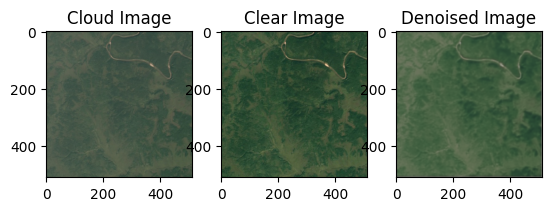

In [50]:
def restore_image(img_tensor, original_size=(512, 512)):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1)
    img_original = img_tensor * std + mean  # 反归一化
    img_original = (img_original * 255).clamp(0, 255).byte()  # 恢复到 [0, 255]
    img_resized = resize(img_original, original_size)  # 调整回原大小
    return img_resized

cloud_img, clear_img = next(iter(dataloader))

i = 4
# 显示结果
plt.subplot(1, 3, 1)
plt.title("Cloud Image")

print(cloud_img[i].shape)
plt.imshow(restore_image(cloud_img[i]).cpu().squeeze().permute(1, 2, 0).numpy())

plt.subplot(1, 3, 2)
plt.title("Clear Image")
plt.imshow(restore_image(clear_img[i]).cpu().squeeze().permute(1, 2, 0).numpy())

denoised_img = denoise_image(model, cloud_img[i].unsqueeze(0).to(device), timesteps)
denoised_img = denoised_img[0].cpu()

plt.subplot(1, 3, 3)
plt.title("Denoised Image")
plt.imshow(restore_image(denoised_img).squeeze().permute(1, 2, 0).numpy())
plt.show()